#                            **Introduction**

#### Anomaly Detection and Failure Prediction using the AI4I 2020 Dataset

This notebook demonstrates a complete end-to-end machine learning project. We will use the AI4I 2020 Predictive Maintenance dataset to build a model that predicts machine failures based on sensor data. This project showcases data exploration, advanced preprocessing techniques, model building with a scikit-learn Pipeline, and insightful visualizations.

# 1. Install and Import Libraries



In [ ]:
# Install any specific libraries if needed (though most are pre-installed)
# !pip install pandas scikit-learn matplotlib seaborn

# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries for effective communication
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for machine learning Models / tasks
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 2. Load the Dataset

In [ ]:
!unzip ai4i2020.zip

Archive:  ai4i2020.zip
  inflating: predictive_maintenance.csv  


In [ ]:
# Load the dataset directly from a public URL or upload it to your Colab environment
# Dataset Source: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
df = pd.read_csv('ai4i2020.csv')

# Display the first few rows to confirm the data is loaded correctly
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


# 3. Exploratory Data Analysis (EDA)

**--- Dataset Info ---**

In [ ]:
print("\n--- Dataset Info ---")
df.info()


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


**--- Descriptive Statistics ---**

In [ ]:
print("\n--- Descriptive Statistics ---")
print(df.describe())


--- Descriptive Statistics ---
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000    

**--- Class Distribution of Machine Failures ---**

In [ ]:
print("\n--- Class Distribution of Machine Failures ---")
print(df['Target'].value_counts())


--- Class Distribution of Machine Failures ---
Target
0    9661
1     339
Name: count, dtype: int64


**--- Visualize Relationships with Target Variable (Failure) ---**

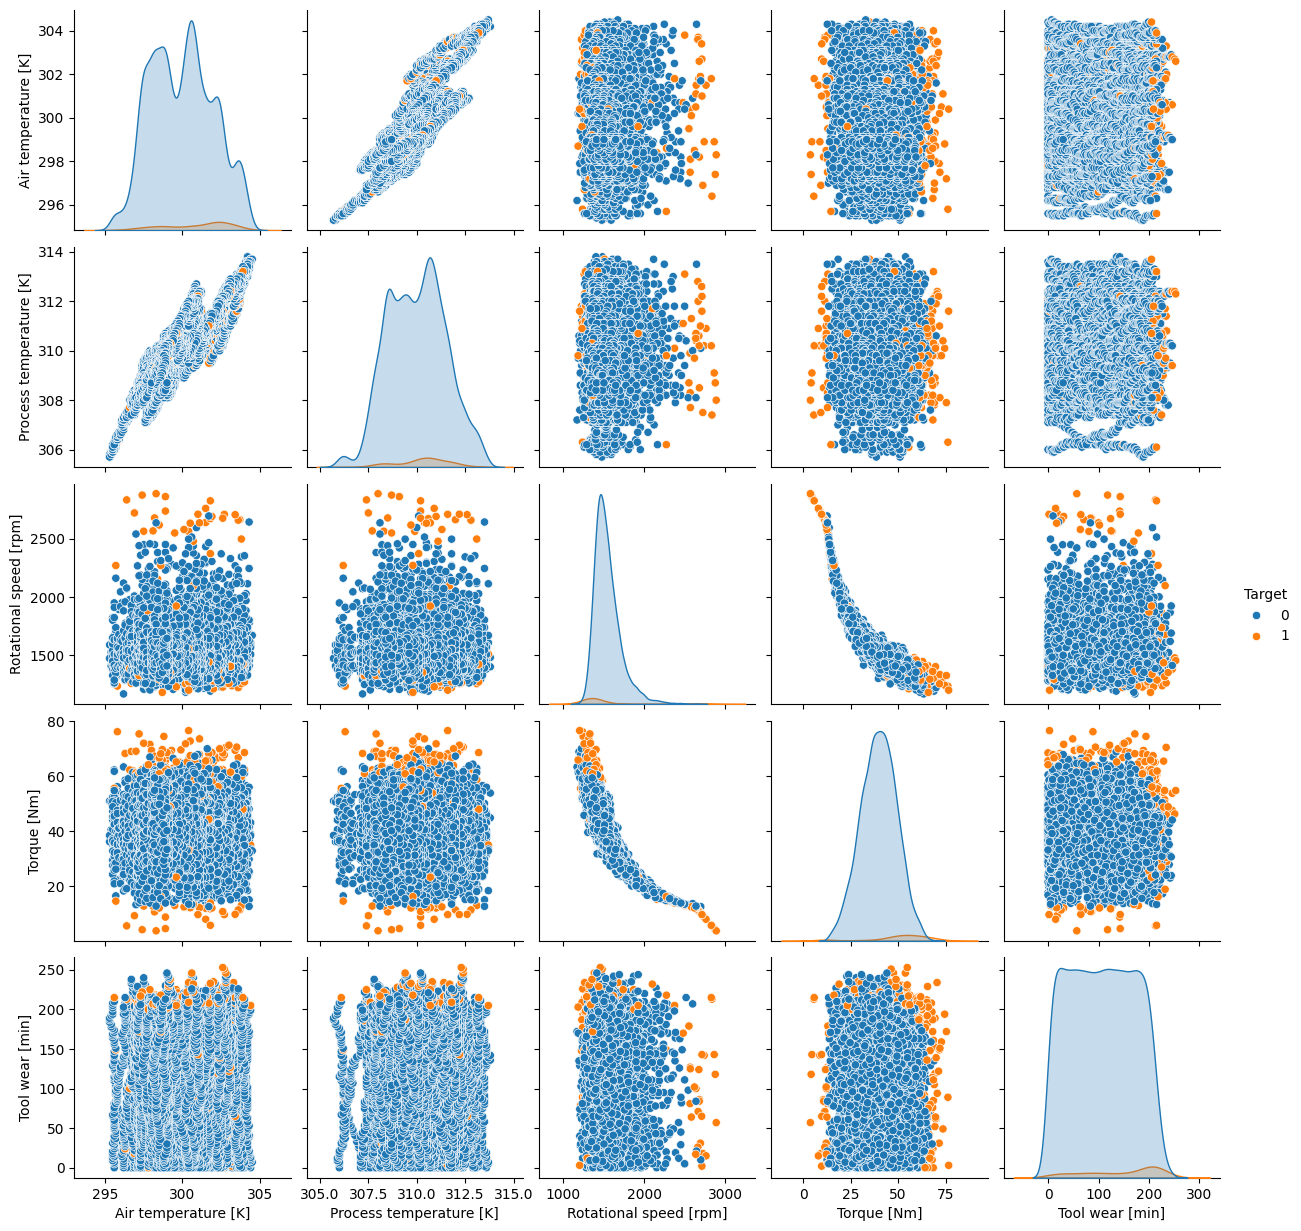

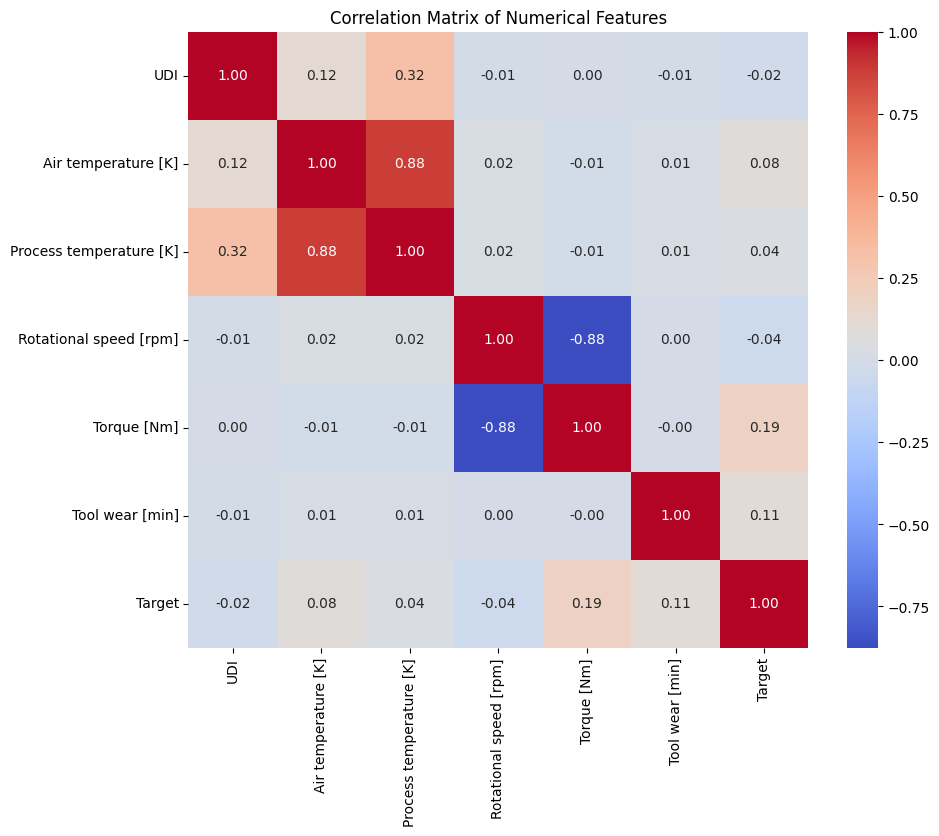

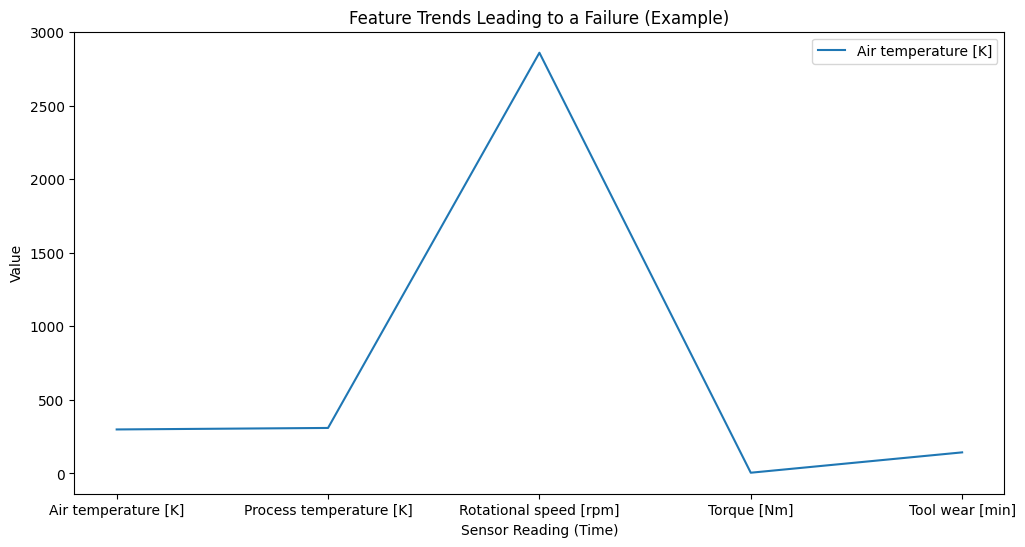

In [ ]:
# --- Visualize Relationships with Target Variable (Failure) ---

# Use pair plots to visualize relationships between numerical features and the target.
# This is a powerful way to find patterns.
sns.pairplot(df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target']], hue='Target')
plt.show()

# Create a correlation heatmap to show feature relationships
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# This is an "advanced" visualization that shows how features change over time for failures.
# We'll plot a single example of a failure to see the sensor readings leading up to it.
failure_example = df[df['Target'] == 1].iloc[0]
time_series_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
plt.figure(figsize=(12, 6))
plt.plot(failure_example[time_series_features])
plt.title('Feature Trends Leading to a Failure (Example)')
plt.legend(time_series_features)
plt.xlabel('Sensor Reading (Time)')
plt.ylabel('Value')
plt.show()

# 4. Data Preprocessing with a Pipeline

In [ ]:
# Define features and target
X = df.drop(columns=['UDI', 'Product ID', 'Target'])
y = df['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Stratify ensures the same proportion of failures in both sets

# Identify categorical and numerical columns
categorical_features = ['Type']
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Create preprocessor pipelines for numerical and categorical features
numerical_transformer = StandardScaler() # This handles numerical scaling
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # This handles categorical encoding

# Use ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the final machine learning pipeline
# The pipeline first preprocesses the data and then trains the model.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5. Model Training and Evaluation


--- Model Evaluation ---
Accuracy: 0.9805

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.89      0.49      0.63        68

    accuracy                           0.98      2000
   macro avg       0.94      0.74      0.81      2000
weighted avg       0.98      0.98      0.98      2000



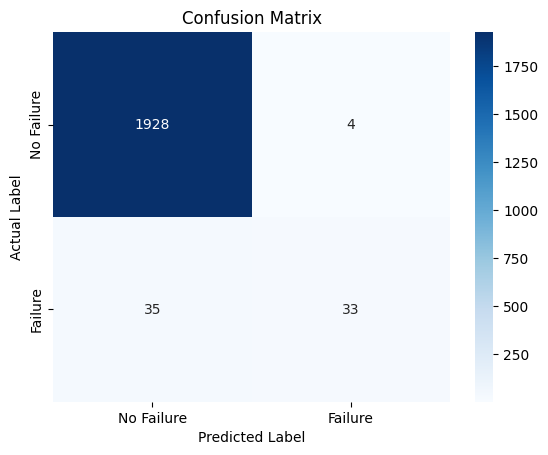

Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Best Model from Hyperparameter Tuning ---
Best parameters found: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best F1-score: 0.6524608066337202

Classification Report (Tuned Model):

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.89      0.49      0.63        68

    accuracy                           0.98      2000
   macro avg       0.94      0.74      0.81      2000
weighted avg       0.98      0.98      0.98      2000



In [ ]:
# Train the pipeline on the training data
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# --- Evaluate Model Performance ---

print("\n--- Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print the full classification report, which is more useful for imbalanced data
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix to understand prediction errors
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Advanced: Hyperparameter Tuning (Optional but highly recommended) ---
# This shows you went the extra mile to optimize the model.
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5]
}

# GridSearchCV performs an exhaustive search over the specified parameter values.
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

print("\n--- Best Model from Hyperparameter Tuning ---")
print("Best parameters found:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Re-evaluate with the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nClassification Report (Tuned Model):\n")
print(classification_report(y_test, y_pred_best))